In [1]:
import sys
sys.path.append('../')

import pandas as pd
import stock_service as sv

In [2]:
sv.run().keys()

dict_keys(['meta_data', 'data_for_all_days'])

In [3]:
pd.json_normalize(sv.run()['meta_data']).T

,0
1. Information,Daily Prices and Volumes for Digital Currency
2. Digital Currency Code,BTC
3. Digital Currency Name,Bitcoin
4. Market Code,CNY
5. Market Name,Chinese Yuan
6. Last Refreshed,2020-07-11 00:00:00
7. Time Zone,UTC


In [4]:
data_for_all_days = pd.json_normalize(sv.run()['data_for_all_days']).T

In [5]:
data_for_all_days.head()

,0
2020-07-11.1a. open (CNY),64999.80332000
2020-07-11.1b. open (USD),9288.34000000
2020-07-11.2a. high (CNY),65076.36144000
2020-07-11.2b. high (USD),9299.28000000
2020-07-11.3a. low (CNY),64878.38802000


In [6]:
data_for_all_days.columns = ['value']

In [7]:
# data
data_for_all_days['date'] = pd.to_datetime(data_for_all_days.index.map(lambda x: x[:10] if len(x) <= 26 else None))

# category
data_for_all_days['category'] =  data_for_all_days.index.map(lambda x: x[11:13] if len(x) <= 26 else None)

# status
data_for_all_days['status'] =  data_for_all_days.index.map(lambda x: x[15:18] if len(x) <= 26 else None)
adjust_dict_status = dict(
    ope = 'open',
    hig = 'high',
    clo = 'close',
    olu = 'volume'
)
data_for_all_days['status'] = data_for_all_days['status'].replace(adjust_dict_status)

# coin conversion
def get_coin(string : str):
    index_parenteses = string.find('(')
    if index_parenteses > 0:
        return string[index_parenteses+1:index_parenteses+4]
    return 'BTC'
data_for_all_days['coin_conversion'] = data_for_all_days.index.map(lambda x: get_coin(x) if len(x) <= 26 else None)

In [8]:
data_for_all_days.head(10)

,value,date,category,status,coin_conversion
2020-07-11.1a. open (CNY),64999.80332000,2020-07-11,1a,open,CNY
2020-07-11.1b. open (USD),9288.34000000,2020-07-11,1b,open,USD
2020-07-11.2a. high (CNY),65076.36144000,2020-07-11,2a,high,CNY
2020-07-11.2b. high (USD),9299.28000000,2020-07-11,2b,high,USD
2020-07-11.3a. low (CNY),64878.38802000,2020-07-11,3a,low,CNY
2020-07-11.3b. low (USD),9270.99000000,2020-07-11,3b,low,USD
2020-07-11.4a. close (CNY),64983.70792000,2020-07-11,4a,close,CNY
2020-07-11.4b. close (USD),9286.04000000,2020-07-11,4b,close,USD
2020-07-11.5. volume,765.18906800,2020-07-11,5.,volume,BTC
2020-07-11.6. market cap (USD),765.18906800,NaT,None,None,None


In [9]:
data_for_all_days = data_for_all_days.dropna()
data_for_all_days.index = data_for_all_days.date

In [10]:
data_for_all_days_usd = data_for_all_days.loc[data_for_all_days.coin_conversion == 'USD']
data_for_all_days_cny = data_for_all_days.loc[data_for_all_days.coin_conversion == 'CNY']

In [11]:
temp_df =  pd.DataFrame()
temp_df['open'] = data_for_all_days_usd.loc[data_for_all_days_usd.status == 'open'].value
temp_df['high'] = data_for_all_days_usd.loc[data_for_all_days_usd.status == 'high'].value
temp_df['low'] = data_for_all_days_usd.loc[data_for_all_days_usd.status == 'low'].value
temp_df['close'] = data_for_all_days_usd.loc[data_for_all_days_usd.status == 'close'].value
temp_df.index = data_for_all_days_usd.loc[data_for_all_days_usd.status == 'open'].index

In [12]:
data_for_all_days_usd = temp_df

In [13]:
import matplotlib.dates as mpl_dates
from mpl_finance import candlestick_ohlc
data_for_all_days_usd['date'] = data_for_all_days_usd.index
data_for_all_days_usd['date'] = data_for_all_days_usd['date'].apply(mpl_dates.date2num)
data_for_all_days_usd = data_for_all_days_usd.astype(float)

/home/aantunesnds/.local/share/virtualenvs/stock-market-6rWeV0cO/lib/python3.6/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [14]:
data_for_all_days_usd = data_for_all_days_usd[['date', 'open', 'high', 'low', 'close']]

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

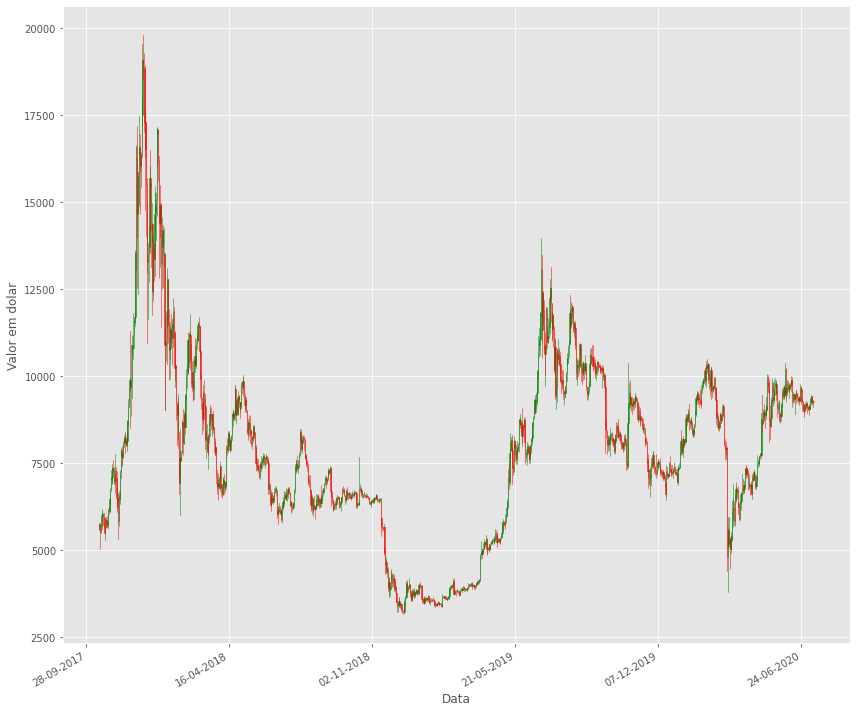

In [16]:
def plot_candle(df):
    
    # Creating Subplots
    fig, ax = plt.subplots(figsize=(12,10))

    candlestick_ohlc(ax, 
                     df.values, 
                     width=0.6, 
                     colorup='green', 
                     colordown='red', 
                     alpha=0.8)

    # Setting labels & titles
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor em dolar')

    # Formatting Date
    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    fig.tight_layout()

    return plt.show()

plot_candle(data_for_all_days_usd)

In [17]:
data_for_all_days_usd.index.year

Int64Index([2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='date', length=1000)

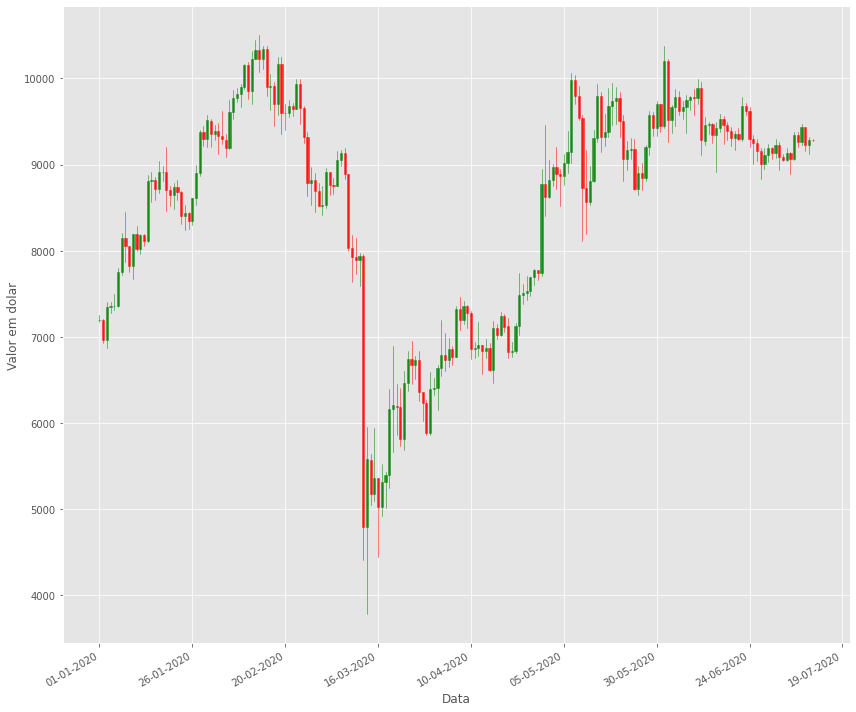

In [18]:
df_2020 = data_for_all_days_usd.loc[data_for_all_days_usd.index.year == 2020]
plot_candle(df_2020)

In [19]:
df_2020.index.month

Int64Index([7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
            ...
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
           dtype='int64', name='date', length=193)

In [20]:
df_jun_2020 = df_2020.loc[df_2020.index.month >= 6]

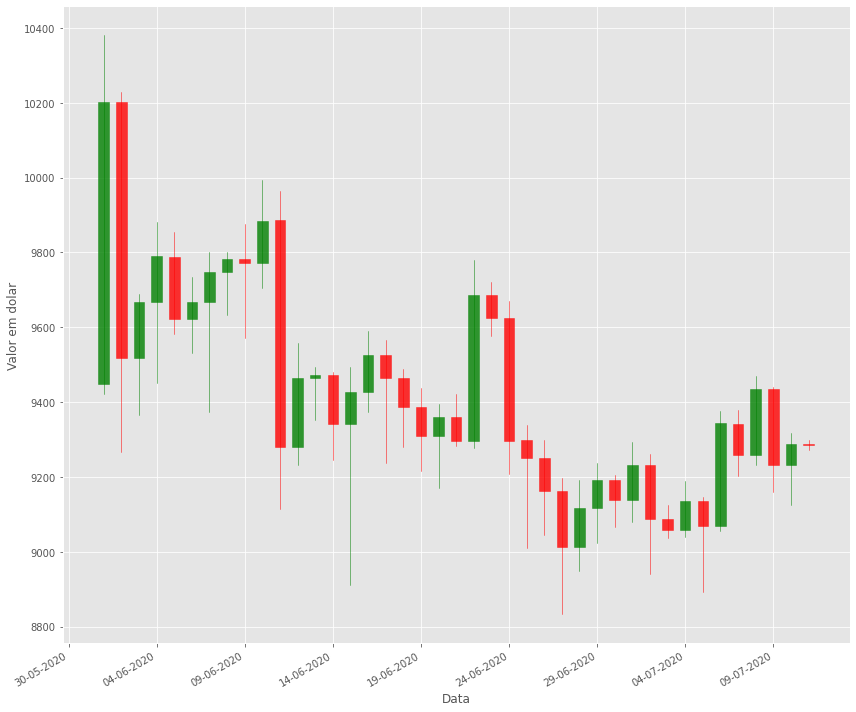

In [21]:
plot_candle(df_jun_2020)